In [3]:
import pickle
import json

from collections import defaultdict, OrderedDict
from copy import deepcopy

from geoloc_imc_2023.query_api import get_measurements_from_tag
from geoloc_imc_2023.default import ANCHOR_TARGET_PROBE_VP, ANCHOR_TARGET_ANCHOR_VP, ANCHOR_TARGET_ALL_VP
from geoloc_imc_2023.measurement_utils import load_atlas_anchors, load_atlas_probes
from geoloc_imc_2023.helpers import distance, rtt_to_km

## load results

In [2]:
uuids = [
    "8ac19a02-d964-4aef-b233-d272d0d08669"
    "9b2dcfb5-1fde-4b95-810b-ada4d1277d48"
]

measurement_results = {}
for uuid in uuids:
    measurement_result = get_measurements_from_tag(uuid)
    measurement_results.update(measurement_result)

with open(ANCHOR_TARGET_PROBE_VP,"wb") as f:
    pickle.dump(measurement_results, f)

with open("../data/anchor_target_probe_vp_raw.pickle","wb") as f:
    pickle.dump(measurement_results, f)

## parse raw results

In [16]:
target_dataset = load_atlas_anchors()
vp_dataset = load_atlas_probes()

# check, for each target that they belong to target dataset, do the same for vps
with open("../data/anchor_target_probe_vp_raw.pickle","rb") as f:
    measurement_results = pickle.load(f)

print(f"number of targets measurements: {len(measurement_results)}")


number of targets measurements: 780


In [25]:
with open("../datasets/removed_probes.json", "r") as f:
    removed_probes = json.load(f)

target_dataset = load_atlas_anchors()
vp_dataset = load_atlas_probes()

with open("../data/anchor_target_probe_vp_raw.pickle","rb") as f:
    measurement_results = pickle.load(f)

In [ ]:
print("nb raw results: ", len(measurement_results))

iterator = deepcopy(measurement_results)
for i, target in enumerate(iterator):

    # check that target in target dataset
    try:
        target_description = target_dataset[target]
    except KeyError:
        print("target error")
        measurement_results.pop(target)
        continue

    # check if target in removed probes
    if target in removed_probes:
        measurement_results.pop(target)
        continue

    # check that all vps are in vps dataset
    tmp_vps = deepcopy(measurement_results[target])
    for vp in tmp_vps:
        # check that target in target dataset
        try:
            vp_description = vp_dataset[vp]
        except KeyError:
            measurement_results[target].pop(vp)
            continue

        # check if vp in removed probes
        if vp in removed_probes:

            measurement_results[target].pop(vp)
            continue

        # remove target from vps
        if vp == target:
            measurement_results[target].pop(vp)
            continue

print("nb target measurements after filtering:", len(measurement_results))

# save results
with open(ANCHOR_TARGET_PROBE_VP, "wb") as f:
    pickle.dump(measurement_results, f)

## ADD ANCHORS MEASUREMENT RESULTS

In [ ]:
anchors = load_atlas_anchors()

with open(ANCHOR_TARGET_ANCHOR_VP, "rb") as f:
    anchors_measurement_results = pickle.load(f)

with open(ANCHOR_TARGET_PROBE_VP, "rb") as f:
    probe_measurement_results = pickle.load(f)

print("probe measurement results len: ", len(probe_measurement_results))

In [6]:
print("number of target to analyze:",len(probe_measurement_results))
for i, target in enumerate(probe_measurement_results):
    if i > 10:
        break
    print(f"target: {target}, nb_measurements :{len(probe_measurement_results[target])}")

number of target to analyze: 751
target: 213.225.160.239, nb_measurements :9635
target: 145.220.0.55, nb_measurements :9625
target: 192.65.184.54, nb_measurements :9605
target: 185.42.136.158, nb_measurements :9599
target: 197.80.104.36, nb_measurements :9614
target: 200.7.84.24, nb_measurements :9635
target: 76.26.115.194, nb_measurements :9608
target: 194.150.191.46, nb_measurements :9642
target: 199.10.66.231, nb_measurements :9614
target: 5.57.16.65, nb_measurements :9647
target: 5.57.17.65, nb_measurements :9621


In [7]:
# save results
with open(ANCHOR_TARGET_ALL_VP, "wb") as f:
    pickle.dump(probe_measurement_results, f)

# Plot results

In [1]:
import pickle
import logging
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt 

from collections import OrderedDict
from copy import deepcopy

from geoloc_imc_2023.default import DATA_PATH, FIGURE_PATH
from geoloc_imc_2023.measurement_utils import load_atlas_anchors, load_atlas_probes

NB_TRIAL = 100

font = {#'family' : 'normal',
    'weight' : 'bold',
    'size'   : 16
}
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

fontsize_axis = 17
font_size_alone = 14

matplotlib.rc('font', **font)

logger = logging.getLogger()

def ecdf(data, array: bool=True):
    """Compute ECDF for a one-dimensional array of measurements."""
    # Number of data points: n
    n = len(data)
    # x-data for the ECDF: x
    x = np.sort(data)
    # y-data for the ECDF: y
    y = np.arange(1, n+1) / n
    if not array:
        return pd.DataFrame({'x': x, 'y': y})
    else:
        return x, y


In [2]:
result_path = DATA_PATH / "anchor_target_probe_vp_result_file.pickle"

with open(result_path, "rb") as f:
    figure_results = pickle.load(f)

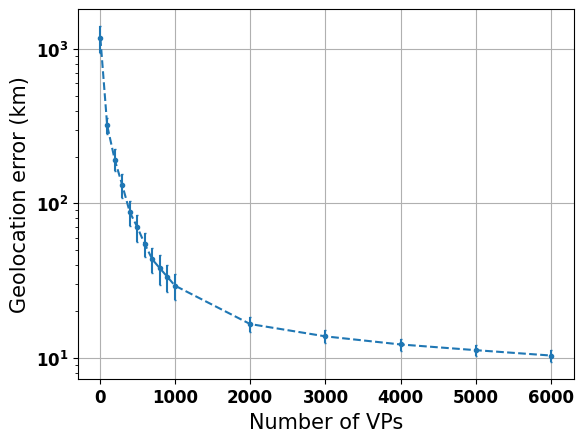

In [3]:
x = np.array([vp_set_size for vp_set_size in figure_results["cbg"]])
y = np.array(
    [
        figure_results["cbg"][vp_set_size]["median_error"]
        for vp_set_size in figure_results["cbg"]
    ]
)
e = np.array(
    [
        figure_results["cbg"][vp_set_size]["deviation"]
        for vp_set_size in figure_results["cbg"]
    ]
)
plt.errorbar(x, y, e, marker=".", capsize=1, linestyle="--")

plt.xlabel("Number of VPs", fontsize=15)
plt.ylabel("Geolocation error (km)", fontsize=15)
plt.tick_params(labelsize=12)
plt.yscale("log")
plt.grid()
plt.savefig(FIGURE_PATH / "cbg/figure_3_a_anchor_target_probe_vp_cbg.png")
plt.savefig(FIGURE_PATH / "cbg/figure_3_a_anchor_target_probe_vp_cbg.pdf")
plt.show()

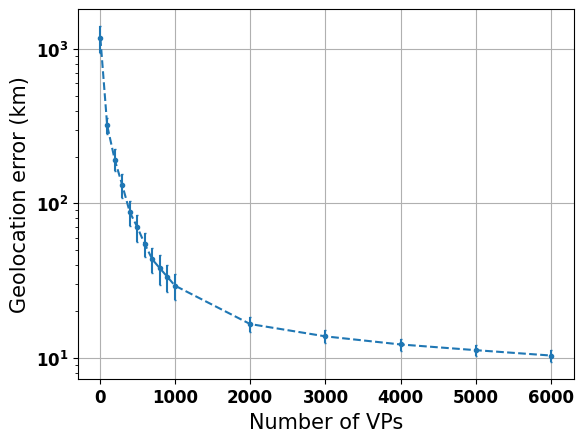

In [4]:
nb_samples = len(figure_results["shortest_ping"]) + 1
step = 5

x2 = np.array([vp_set_size for vp_set_size in figure_results["cbg"]])
y2 = np.array(
    [
        figure_results["shortest_ping"][vp_set_size]["median_error"]
        for vp_set_size in figure_results["shortest_ping"]
    ]
)
e2 = np.array(
    [
        figure_results["shortest_ping"][vp_set_size]["deviation"]
        for vp_set_size in figure_results["shortest_ping"]
    ]
)
plt.errorbar(x2, y2, e2, marker=".", capsize=1, linestyle="--")
plt.xlabel("Number of VPs", fontsize=15)
plt.ylabel("Geolocation error (km)", fontsize=15)
plt.yscale("log")
plt.tick_params(labelsize=12)
plt.grid()
plt.savefig(
    FIGURE_PATH / "shortest_ping/figure_3_a_anchor_target_probe_vp_shortest_ping.png"
)
plt.savefig(
    FIGURE_PATH / "shortest_ping/figure_3_a_anchor_target_probe_vp_shortest_ping.pdf"
)
plt.show()

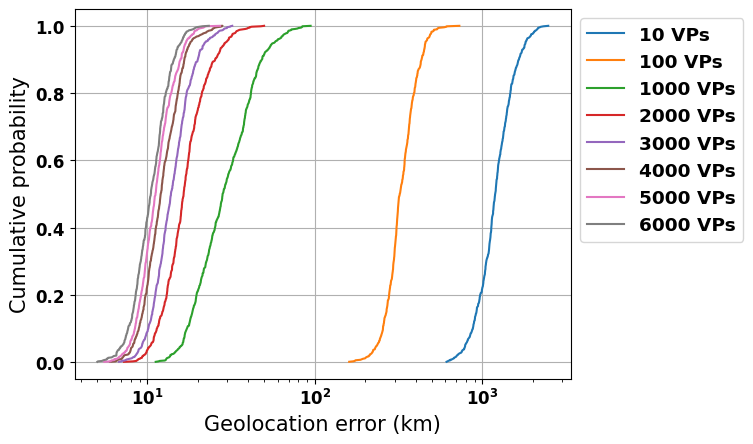

In [6]:
fig, ax = plt.subplots()

for vp_set_size in [10,100, 1000, 2000, 3000, 4000, 5000, 6000]:
    subset_results = []
    vp_subset_results = figure_results["cbg"][vp_set_size]["data"]
    for i in range(0, len(vp_subset_results), NB_TRIAL):
        subset_results.append(np.median(vp_subset_results[i : i + NB_TRIAL]))

    x, y = ecdf(subset_results)
    ax.plot(x, y, label=f"{vp_set_size} VPs")

legend = ax.legend(loc="upper left", bbox_to_anchor=(1, 1), fontsize = "small")
legend.get_frame()

plt.xlabel("Geolocation error (km)", fontsize=15)
plt.ylabel("Cumulative probability", fontsize=15)
plt.tick_params(labelsize=12)
plt.xscale("log")
plt.grid()
plt.savefig(FIGURE_PATH / "cbg/figure_3_b_anchor_target_probe_vp_cbg.png", bbox_inches='tight')
plt.savefig(FIGURE_PATH / "cbg/figure_3_b_anchor_target_probe_vp_cbg.pdf", bbox_inches='tight')
plt.show()

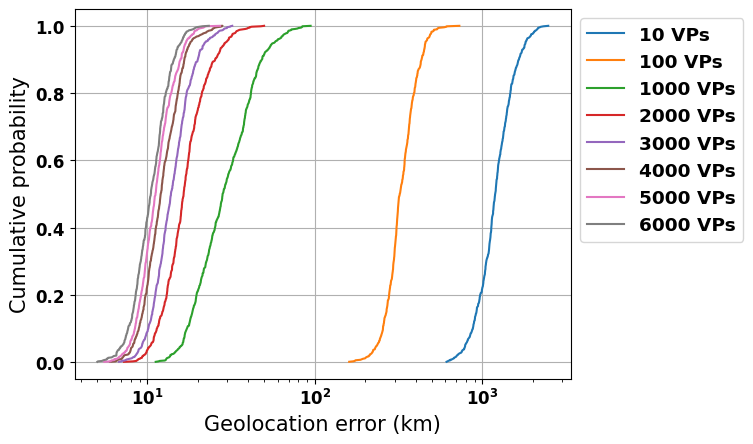

In [7]:
import seaborn as sns


fig, ax = plt.subplots()

for vp_set_size in [10,100, 1000, 2000, 3000, 4000, 5000, 6000]:
    subset_results = []
    vp_subset_results = figure_results["shortest_ping"][vp_set_size]["data"]
    for i in range(0, len(vp_subset_results), NB_TRIAL):
        subset_results.append(np.median(vp_subset_results[i : i + NB_TRIAL]))

    x, y = ecdf(subset_results)
    ax.plot(x, y, label=f"{vp_set_size} VPs")

legend = ax.legend(loc="upper left", bbox_to_anchor=(1, 1), fontsize="small")
legend.get_frame()

plt.xscale("log")
plt.grid()
plt.xlabel("Geolocation error (km)", fontsize=15)
plt.ylabel("Cumulative probability", fontsize=15)
plt.tick_params(labelsize=12)
plt.savefig(FIGURE_PATH / "shortest_ping/figure_3_b_anchor_target_probe_vp_shortest_ping.png", bbox_inches='tight')
plt.savefig(FIGURE_PATH / "shortest_ping/figure_3_b_anchor_target_probe_vp_shortest_ping.pdf", bbox_inches='tight')
plt.show()